In [1]:
import pandas as pd
import numpy as np
import pickle
from numpy import random
from itertools import combinations

from gensim.utils import simple_preprocess

from gensim.corpora import Dictionary
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_json('data/dev/cluster_12_cats.json')

In [3]:
df.head()

,id,date,title,body,subjects,category
0,3-6475275,2013-01-31T16:59:42+0200,Aika kallis Volkkari,Vuonna 1973 autonvalmistaja Volkswagen oli kr...,"[tekniikka, ulkomaat, liikenne, vw passat, vol...",autot
1,3-6475075,2013-01-31T16:02:43+0200,Kuopion koruryöstäjille kymmenien tuhansien sa...,Poliisi kaipaa edelleen havaintoja keskiviikk...,"[kotimaan uutiset, ryöstö, varallisuusrikokset...",autot
2,3-6474561,2013-01-31T13:24:08+0200,Nuori nainen kuoli kolarissa Virroilla,Etelä-Pohjanmaalla asuva nuori nainen menehty...,"[virrat, räntä, liikenneonnettomuudet, henkilö...",autot
3,3-6474214,2013-01-31T10:54:11+0200,Autoasentajat kurssikierteessä,Kun auton polttimonvaihto vie alan korjaamoll...,"[kotimaan uutiset, tekniikka, tuulilasinpesin,...",autot
4,3-6474222,2013-01-31T10:54:01+0200,12 kertaa kiinni kortitta ajosta,Kokemäellä autoillut mies jäi keskiviikkona k...,"[ajokortitta ajaminen, kokemäki, liikennerikko...",autot


In [4]:
df['title'] = df['title'].astype(str)
df['body'] = df['body'].astype(str)

In [5]:
df['body'] = df['title'] + ' ' + df['body']

In [6]:
%%time
tokenized = df['body'].apply(simple_preprocess)

CPU times: user 59.1 s, sys: 994 ms, total: 1min
Wall time: 1min


In [7]:
doc_lengths = tokenized.apply(lambda x: len(x))

print("length of list:",len(doc_lengths),
      "\naverage document length", doc_lengths.mean(),
      "\nminimum document length", doc_lengths.min(),
      "\nmaximum document length", doc_lengths.max(),
      "\nnumber document less than {} words:".format(20), (doc_lengths < 20).sum(),
      "\nnumber document more than {} words:".format(1000), (doc_lengths > 1000).sum())

length of list: 207881 
average document length 203.3456977790178 
minimum document length 0 
maximum document length 18705 
number document less than 20 words: 1492 
number document more than 1000 words: 1194


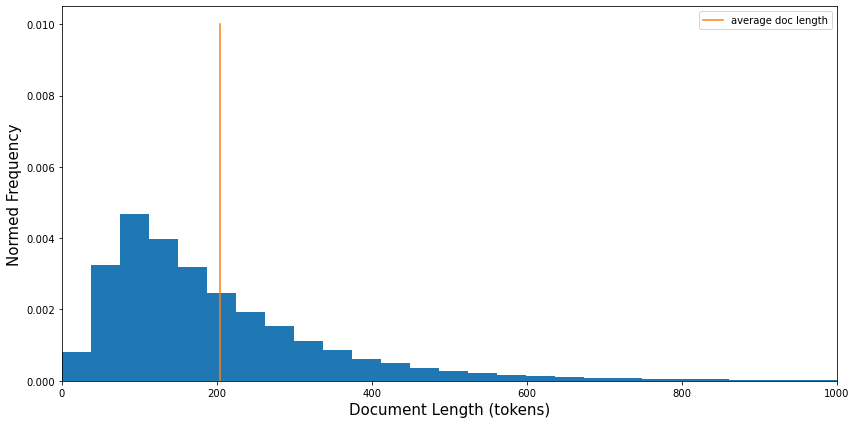

In [8]:
# plot a histogram of document length
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
n, bins, patches = ax.hist(doc_lengths, bins=500, density=1)
ax.set_xlabel('Document Length (tokens)', fontsize=15)
ax.set_ylabel('Normed Frequency', fontsize=15)
ax.grid()

plt.xlim(0, 1000)
# plt.ylim(0, 1)
ax.plot([np.average(doc_lengths) for i in np.linspace(0.0, 0.01, 10)], np.linspace(0.0, 0.01, 10), '-',
        label='average doc length')
ax.legend()
ax.grid()
fig.tight_layout()
plt.show()

In [9]:
df['doc_len'] = doc_lengths
df['tokens'] = tokenized

In [10]:
# filter out documents < 20 or > 1000 tokens
df_filtered = df[(df['doc_len'] > 20) & (df['doc_len'] < 1000)]

In [11]:
df_filtered.shape

(205031, 8)

In [12]:
df_filtered.head()

,id,date,title,body,subjects,category,doc_len,tokens
0,3-6475275,2013-01-31T16:59:42+0200,Aika kallis Volkkari,Aika kallis Volkkari Vuonna 1973 autonvalmist...,"[tekniikka, ulkomaat, liikenne, vw passat, vol...",autot,434,"[aika, kallis, volkkari, vuonna, autonvalmista..."
1,3-6475075,2013-01-31T16:02:43+0200,Kuopion koruryöstäjille kymmenien tuhansien sa...,Kuopion koruryöstäjille kymmenien tuhansien sa...,"[kotimaan uutiset, ryöstö, varallisuusrikokset...",autot,164,"[kuopion, koruryöstäjille, kymmenien, tuhansie..."
2,3-6474561,2013-01-31T13:24:08+0200,Nuori nainen kuoli kolarissa Virroilla,Nuori nainen kuoli kolarissa Virroilla Etelä-...,"[virrat, räntä, liikenneonnettomuudet, henkilö...",autot,72,"[nuori, nainen, kuoli, kolarissa, virroilla, e..."
3,3-6474214,2013-01-31T10:54:11+0200,Autoasentajat kurssikierteessä,Autoasentajat kurssikierteessä Kun auton polt...,"[kotimaan uutiset, tekniikka, tuulilasinpesin,...",autot,351,"[autoasentajat, kun, auton, polttimonvaihto, v..."
4,3-6474222,2013-01-31T10:54:01+0200,12 kertaa kiinni kortitta ajosta,12 kertaa kiinni kortitta ajosta Kokemäellä a...,"[ajokortitta ajaminen, kokemäki, liikennerikko...",autot,42,"[kertaa, kiinni, kortitta, ajosta, kokemäellä,..."


In [13]:
df_filtered.iloc[0]['title']

'Aika kallis Volkkari'

In [14]:
df_filtered.to_pickle('data/prod/yle-articles-tokens.pkl')

In [15]:
df_filtered.reset_index(inplace=True, drop=True)

In [16]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(df_filtered['tokens'])]

In [17]:
model = Doc2Vec(vector_size=128, min_count=2, workers=4, dbow_words=1, negative=5)

In [18]:
%%time
model.build_vocab(documents)

CPU times: user 2min 40s, sys: 1.62 s, total: 2min 42s
Wall time: 2min 43s


In [19]:
%%time
model.train(documents, total_examples=model.corpus_count, epochs=30)

CPU times: user 1h 16min 46s, sys: 1min 52s, total: 1h 18min 38s
Wall time: 26min 10s


In [20]:
model.save('models/doc2vec/doc2vec_train')

In [21]:
# now we will validate if the model able to find the document itself is the most similar one
doc_id = 2

In [22]:
inferred_vector = model.infer_vector(documents[doc_id].words)
sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))

In [23]:

print('Document ({}): «{}»\n'.format(doc_id, ' '.join(documents[doc_id].words)))
print(u'SIMILAR/DISSIMILAR DOCS PER MODEL %s:\n' % model)
for label, index in [('MOST', 0), ('SECOND-MOST', 1), ('MEDIAN', len(sims)//2), ('LEAST', len(sims) - 1)]:
    print(u'%s %s: «%s»\n' % (label, sims[index], ' '.join(documents[sims[index][0]].words)))

Document (2): «nuori nainen kuoli kolarissa virroilla etelä pohjanmaalla asuva nuori nainen menehtyi henkilöauton ja rekan onnettomuus sattui loskaisessa ajokelissä henkilöauton kuljettaja sai surmansa torstaiaamuna rekka auton kanssa virroilla menehtynyt oli etelä pohjanmaalla asuva vuonna syntynyt nainen hän oli ajoneuvossa yksin turma sattui yhdeksän jälkeen aamulla kantatiellä muutama kilometri virtain keskustasta alavuden suuntaan nainen ohitti edellään ajaneen pakettiauton ja joutui sen jälkeen sivuluisuun jolloin auto törmäsi vastaan tulleeseen rekkaan tie oli loskainen ja märkä»

SIMILAR/DISSIMILAR DOCS PER MODEL Doc2Vec(dm/m,d128,n5,w5,mc2,s0.001,t4):

MOST (2, 0.9363793730735779): «nuori nainen kuoli kolarissa virroilla etelä pohjanmaalla asuva nuori nainen menehtyi henkilöauton ja rekan onnettomuus sattui loskaisessa ajokelissä henkilöauton kuljettaja sai surmansa torstaiaamuna rekka auton kanssa virroilla menehtynyt oli etelä pohjanmaalla asuva vuonna syntynyt nainen hän ol

In [24]:
model.wv.most_similar('tehokkaalla')

[('mainiolla', 0.6378647685050964),
 ('vahvalla', 0.573211133480072),
 ('iloisella', 0.5641483664512634),
 ('väkevällä', 0.5557291507720947),
 ('laadukkaalla', 0.5479243993759155),
 ('kevyellä', 0.5386682748794556),
 ('heikolla', 0.5386379957199097),
 ('kauniilla', 0.5373977422714233),
 ('loistavalla', 0.5348361730575562),
 ('päivittäisellä', 0.5264298915863037)]

In [2]:
# now try to load model and infer the text
# This process would take very long time, we want to do it once
# Then save the infered vecs for uses later
df_filtered = pd.read_pickle('data/prod/yle-articles-tokens.pkl')

In [3]:
d2v_model = Doc2Vec.load('models/doc2vec/doc2vec_train')

In [4]:
# infering to sample docs
def infer_doc2vec(docs, model):
    # tokenize the docs
    tokenized = docs.apply(simple_preprocess)
    vecs = np.zeros((len(docs), model.vector_size))
    
    for i, tokens in enumerate(tokenized):
        vecs[i] = model.infer_vector(tokens)
    
    return vecs

In [5]:
%%time
doc_vecs = infer_doc2vec(df_filtered['body'], d2v_model)

CPU times: user 42min 56s, sys: 3.4 s, total: 43min
Wall time: 43min 13s


In [ ]:
pickle.dump(doc_vecs, open("data/prod/doc_vecs.pkl", "wb"))